# **Impacto de la contaminación por material particulado en la salud respiratoria de los habitantes de Santiago de Chile (2017-2019)**

## Antecedentes

Este proyecto analiza la relación entre la contaminación atmosférica, específicamente PM₂₅, y el número de consultas por enfermedades respiratorias en la Región Metropolitana de Santiago entre 2017 y 2019. La motivación surge del aumento de episodios críticos de contaminación durante los meses de invierno, periodo en el cual también aumentan significativamente las atenciones respiratorias en los centros de salud públicos.

A partir del trabajo preliminar (2da Entrega), se redefinieron los objetivos originales debido a limitaciones en la disponibilidad y cobertura de ciertos datos (especialmente variables climáticas y socioeconómicas), focalizando el análisis exclusivamente en:

- Datos de polución atmosférica del SINCA.
- Datos de enfermedades respiratorias del DEIS (REM).

Este trabajo incorpora Análisis Exploratorio de Datos y visualizaciones para evaluar si existe evidencia cuantitativa que relacione ambas variables.

En el Análisis Exploratorio de Datos realizado en "2da Entrega" se concluyó que los datos mostraron correlación estacionaria, donde el material particulado y los casos de enfermedades respiratorias incrementaban, pero luego de realizar un análisis geográfico comunal se observó nula coexistencia y relación entre las variables.

## Analisis de Datos

### Metodología

Inicialmente se extrajeron los datasets de la plataforma del [SINCA](https://sinca.mma.gob.cl/index.php/) para los datos de índices de polución del aire en la Región Metropolitana, reportes [REM](https://reportesrem.minsal.cl/) del MINSAL para obtener los datos de los casos de enfermedades en la Región Metropolitana y de la plataforma de mapas vectorizados [BCN](https://www.bcn.cl/siit/mapas_vectoriales) obtuvimos el mapa de todas las comunas de Chile para analizar la relación geográfica de las variables de estudio. 

#### **SINCA:**

El Sistema de Información Nacional de Calidad del Aire (SINCA) del Ministerio del Medio Ambiente de Chile contiene registros horarios de material particulado fino (PM₂₅) de distintas estaciones ubicadas en distintas comunas de Chile. Para objeto de este estudio solo se descarga la información correspondiente a comunas de la Región Metropolitana: Cerro Navia, Pudahuel, Quilicura, El Bosque, Cerrillos, Independencia, Las Condes, La Florida, Puente Alto y Parque O’Higgins. Debido a que la base de datos REM solo tiene datos entre 2017 y 2020 (2020 se descarta debido a que es el año de inicio de pandemia y puede alterar las estadísticas), solo consideraremos los años 2017, 2018 y 2019 de ambas bases de datos. 

Primero se descargaron los datos desde la página https://sinca.mma.gob.cl/index.php/ y en el panel de "información histórica" se seleccionó Región Metropolitana. Por cada comuna (correspondiente al sector donde está instalado el medidor de material particulado) se selecciona la comuna, en el parámetro de "Material particulado MP2.5" en el ítem "registros horarios disponibles" se configuran los rangos de fechas desde 1 de enero 2017 hasta 31 de diciembre de 2019; una vez determinados los datos deseados se descarga el Excel CSV. El procedimiento se repite por cada comuna/medidor. 

Cada .csv tiene columnas como: 

| Columna | Definición |
|----------|----------|
| FECHA (YYMMDD)    | fecha del registro en formato numérico (171225 -> 25 de diciembre del 2017)    |
| HORA (HHMM)    | hora del registro   |
| Registros Válidos    | Mediciones de MP2.5 válidas   |
| Registros Preliminares    | Mediciones de MP2.5 aun sin validar    |
| Registros no Válidos    | Mediciones de MP2.5 descartadas o sin validar    |
| Unnamed5    | columna creada por default al convertir el dataset a .csv    |


Los archivos fueron combinados en un solo DataFrame llamado *df_contaminacion*, agregando una columna estacion que indica la comuna de origen, y se generó una columna unificada PM2.5 que prioriza los registros validados y, cuando estos no existen, utiliza los preliminares. La decisión de unificar los registros validados y preliminares en PM2.5 permite aprovechar todos los datos disponibles sin perder calidad. 

Luego se limpió el dataset normalizando los nombres de las comunas, renombrando las columnas "FECHA (YYMMDD)" y "HORA (HHMM)" por nombres más cortos y se le asignó formato estándar “%y%m%d” y se creó una nueva columna con los datos de la columna “Registros Válidos” y los NaN se completaron con los registrados en la columna “Registros Preliminares” y se eliminaron las columnas “Registros no Válidos” y Unnamed5” que no entregan valores significativos. 

#### **Casos REM del MINSAL:**

**REM** son las siglas de “Registros Estadísticos Mensuales”. Es un instrumento estandarizado de recopilación estadísticas de la producción de atenciones y de la población bajo control en los distintos programas de salud. En su plataforma suben informes mensuales tabulados de datos generados desde establecimientos de salud de la red pública, para monitorear la gestión, evaluar el cumplimiento de programas y tomar decisiones informadas en el sector salud. Estos datos son preliminares, pues todavía están en un proceso de validación y cierre del período, y aún no son la versión final consolidada de las estadísticas mensuales; sin embargo, éstos son cruciales para tener una idea temprana del rendimiento de los servicios de salud y para detectar posibles errores o discrepancias en el registro. 

Extraer estos datos es más complejo, pues son archivos con extensión .xls escrito de trasfondo en html. Primero, para descargar los archivos desde la página https://reportesrem.minsal.cl se deben configurar los parámetros: 

- Serie -> SERIE A 

- Rem -> REMA04. CONSULTAS Y OTRAS ATENCIONES 

- Sección -> SECCIÓN A: CONSULTAS MÉDICAS 

- Desagregación -> REGIONES 

- Regiones -> METROPOLITANA DE SANTIAGO 

- Periodo -> {año (2017, 2018, 2019)} 

- Mes Inicio -> {mes} 

- Mes Final -> {mes} 

Para descargar los datos se descargan mes a mes por cada año. Es decir, por ejemplo: Periodo -> 2017, Mes Inicio -> Enero, Mes Final -> Enero. Esto se repite por cada mes y año, dando un total de 36 archivos.xls. Como se mencionó anteriormente, este formato de archivo no se puede leer directamente, por lo que se implementó una función de lectura y limpieza: 

```python
# con esta función se extraen los datos de los archivos html escondidos en los xls y los retorna en formato DataFrame
def tranformar_html(mes_archivo, anio_archivo, nombre_archivo, carpeta_archivo='data'):
    ruta = os.path.join(carpeta_archivo, 'REM','REM_' + str(anio_archivo), nombre_archivo)
    html_text = open(ruta,'r', encoding='utf-8').read()
    soup = BeautifulSoup(html_text, "html.parser")

    tables = soup.find_all('table')
    body = soup.find('tbody')

    datos = []
    comuna_actual = None
    filas = body.find_all('tr')
    for fila in filas:
        texto_fila = fila.get_text(strip=True).upper()
        
        
        if 'COMUNA:' in texto_fila:
            comuna_actual = texto_fila.split('COMUNA:')[-1].strip().title()
            continue

        if 'ESTABLECIMIENTO:' in texto_fila:
            comuna_actual = None
            continue

        if comuna_actual:
            celdas = fila.find_all('td')
            if len(celdas) >= 2:
                consulta = celdas[0].get_text(strip=True)
                valor = celdas[1].get_text(strip=True)
                if consulta and valor and consulta.upper() != 'TOTAL':
                    datos.append([consulta, valor, comuna_actual, mes_archivo, anio_archivo])
    

    df = pd.DataFrame(datos, columns = ['Consulta_por', 'n_pacientes','Comuna', 'Mes', 'Año'])
    print(f"Datos procesados para {mes_archivo} {anio_archivo}.")

    # conseva solo las columnas que corresponden a areas de enfermedades respiratorias
    df = df[(df['Consulta_por'] != 'OBSTETRICA') & (df['Consulta_por'] != 'GINECOLOGICA') & (df['Consulta_por'] != 'GINECOLOGICA  POR INFERTILIDAD') & (df['Consulta_por'] != 'INFECCIÓN TRANSMISIÓN SEXUAL') & (df['Consulta_por'] != 'VIH-SIDA') & (df['Consulta_por'] != 'SALUD MENTAL') & (df['Consulta_por'] != 'OTRAS MORBILIDADES')]

    return df
```

Este estudio se centra en las enfermedades respiratorias, por lo que la función se encarga de limpiar el dataset para dejar sólo esos casos. La columna “n_pacientes” se convierte a entero, se capitalizaró la columna “Mes”, se creó una nueva columna para convertir a número cada mes y se identificaron las variables categóricas (la columna “Consulta_por”). 

#### **BCN:** 

Este geodataset vectorial se extrajo de https://www.bcn.cl/siit/mapas_vectoriales, donde se seleccionó la opción "División comunal: polígonos de las comunas de Chile", que, como su nombre lo dice, contiene la división poligonal de todas las comunas de chile. Inicialmente se descarga un archivo.zip, el cual al descomprimirlo contiene múltiples archivos; para el estudio se leyó el archivo “comunas.shp”, se reconfiguró su crs y se filtraron las comunas para conservar sólo las relevantes para el estudio mediante filtrado de la columna “Region” conservando aquellas filas que contengas en ese campo “Región Metropolitana de Santiago”.

## Resumen de resultados:

En el análisis exploratorio de datos (EDA) se realizaron 2 tipos de análisis: 

- Numérico 
    - Estadísticas descriptivas 
- Visual: 
    - Gráficos de líneas 
    - Gráficos boxplot
    - Gráficos heatmap 

Éste último con el fin de estudiar relaciones y distribuciones entre las variables.

- **Gráficos de líneas:** Al querer estudiar que tan elevada es la contaminación en distintos años, ver si existe un cambio con el pasar del tiempo. Utilizamos este método estadístico, pues permiten ver tendencias en los periodos de tiempo.  

- **Boxplot:** Estos gráficos con relación a las partículas se distribuyen en las comunas entre los años 2017-2019. Notar que la mediana de Pm2.5 es similar en todas las comunas (20 – 25µg/m³). Podemos decir que la contaminación se mantiene en rangos ‘constantes’ en la región Metropolitana. Se puede ver alta cantidad outliers algunos están sobre 100 g/m³ lo que indica altos niveles de contaminación en algunos periodos de tiempo. Luego también se hicieron boxplot de:
    - Promedio mensual de pacientes por comuna.
    - Promedio mensual de Pm2.5 por estación. 

- **Heatmaps:** El uso de estos gráficos permite de una forma más intuitiva la correlación de las variables. Además, permite ver mejor los patrones, la contaminación se dispara entre los meses de mayo – agosto como pudimos observar. Se observó la relación entre: 
    - Promedio mensual de pacientes por comuna.
    - Promedio mensual de Pm2.5 por estación.

Al final se graficaron en el mapa comunal de la Región Metropolitana los casos respiratorios según los índices de más casos, y en paralelo, según los índices de Pm2.5, se graficaron las comunas con medidores de material particulado Pm2.5.

## Conclusión Final y Estrategias de Política Pública
### 1. Vínculo Cuantificado y Evaluación de Modelos
El análisis de series de tiempo por comuna ha demostrado que el material particulado fino PM2.5 es un predictor significativo, pero heterogéneo, de la demanda de atenciones de urgencia respiratoria (REM) en Santiago.

| Comuna       | Lag Óptimo (Días) | Coeficiente β |   R²   |   MSE   | Interpretación del Modelo                     |
|--------------|-------------------|----------------|--------|---------|-----------------------------------------------|
| Quilicura    | 7                 | 0.346          | 0.297  | 109.47  | Explicativo Fuerte (Exposición Acumulada)     |
| Talagante    | 6                 | 0.324          | 0.272  | 116.18  | Explicativo Fuerte (Exposición Sub-Aguda)     |
| Cerro Navia  | 2                 | 0.293          | 0.141  | 167.71  | Predictor Moderado (Efecto Agudo)             |
| Pudahuel     | 3                 | -0.251         | 0.086  | 153.69  | Anomalía (Correlación Inversa)                |
| Puente Alto  | 0                 | -0.345         | 0.069  | 254.55  | Anomalía (Correlación Inversa)  

#### A. Desempeño y Predictibilidad
Los modelos son más fiables en las comunas donde el R^2 es alto y el MSE es bajo (ej. Quilicura y Talagante). En estos casos, cerca del 30% de la variabilidad en las atenciones se explica por el PM2.5 rezagado, con un error cuadrático promedio de ~ 110 a 116 atenciones al cuadrado. En contraste, el alto MSE de Puente Alto (≈ 255) confirma que la regresión lineal es un modelo inadecuado para esa comuna, probablemente debido a factores no lineales o la influencia de otras variables.

#### B. El Mecanismo Temporal (Lag)
El retraso óptimo varía entre 0 y 7 días, lo que sugiere que el PM2.5 activa diferentes mecanismos biológicos y conductuales:
- **Efecto Sub-Agudo/Acumulativo (6-7 días):** Dominante en Quilicura y Talagante. La correlación más fuerte ocurre a la semana, implicando que el daño se relaciona con la exposición sostenida, activando o agravando condiciones crónicas (asma, EPOC).
- **Efecto Agudo (2 días):** Visto en Cerro Navia y Las Condes, reflejando respuestas inflamatorias inmediatas.

### 2. Hallazgo Anómalo: Correlación Inversa
Las comunas con el PM2.5 más alto (ej. Pudahuel y Puente Alto) presentan coeficientes Beta negativos. Esto significa que cuando la contaminación sube, la demanda de urgencias reportada tiende a bajar.

### 3. Recomendaciones de Política Pública Estratégicas
El principio clave es la diferenciación geográfica y temporal de las estrategias:
1.	Focalización de la Inversión Sanitaria (Regla del R^2): Los recursos para predicción y alerta deben centrarse en Quilicura y Talagante, ya que el modelo de PM2.5 es el más fiable y eficiente para anticipar la demanda de salud (R^2 ≈ 30%).

2.	Sistema de Alerta con Doble Horizonte Temporal:
- **Alerta de Urgencia (Lag 2):** Activar la movilización de personal y camas en comunas como Cerro Navia con 48 horas de anticipación ante peaks pronosticados.
- **Alerta Preventiva y Crónica (Lag 6-7):** Activar campañas de seguimiento telefónico y entrega anticipada de medicamentos a pacientes crónicos en Quilicura y Talagante ante la proyección de una semana de alta polución.
3.	Cuantificación del Beneficio Económico (Uso del Beta): El coeficiente Beta permite monetizar el impacto de la reducción de la contaminación. Por ejemplo, en Quilicura, la reducción sostenida de 1mu g/m^3 de PM2.5 ahorraría el costo de 0.346 atenciones diarias de urgencia, justificando la inversión en políticas de control de emisiones.



![Tabla correlacion.png](<attachment:Tabla correlacion.png>)
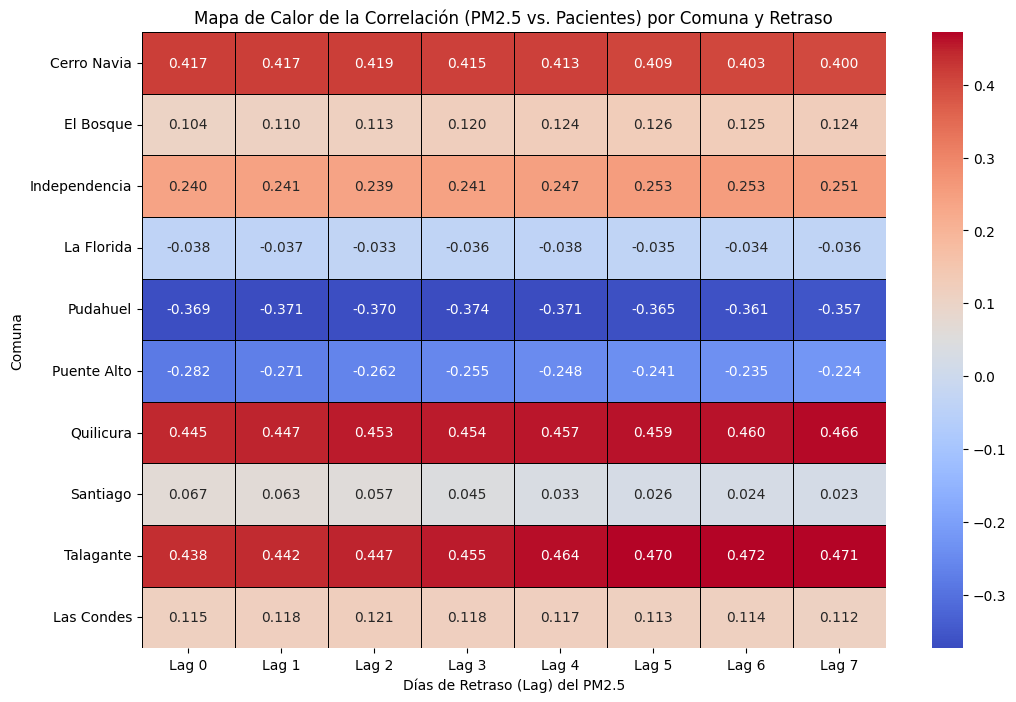

* **¿Qué podría salir mal?:** explique las posibles limitaciones o sesgos de sus datos o análisis. Identifique qué problemas se podrían generar a partir de su solución o de las decisiones que esta recomiende.

## ¿Qué podría salir mal? 

### **Posibles Problemas y soluciones:** 

#### - *Problema (limitación de datos)*

Los datos analizados de enfermedades respiratorias superan en proporción los datos de polución. Éstos últimos solo cubren ciertas áreas geográficas, mientras que los de enfermedades son de toda la Región Metropolitana. Esta limitación puede alterar las conclusiones. 

#### - *Solución*

Si no es posible obtener los datos faltantes (para todas las comunas) lo adecuado sería considerar solo los sectores acerca de los cuales tenemos registro de polución, reduciendo la cantidad de datos de enfermedades respiratorias. 

#### - *Problema de la solución*

La cantidad de datos resultantes sería tan mínima que el análisis no sería representativo de la Región, por lo que los resultados dejarían de ser significativos. 

#### - *Problema (enfermedades respiratorias son multicausales)*

Las enfermedades respiratorias son multicausales y los datos no permiten distinguir que parte del problema es atribuible a la polución. 

#### - *Solución*

Se necesita un estudio que establezca las variables más relevantes en la generación de enfermedades respiratorias para incorporar esos datos al modelo y así buscar establecer cuánto de las enfermedades respiratorias se puede asociar efectivamente a la polución. 

#### - *Problema de la solución*

Es difícil conseguir estos datos (estudio) y hacerlos comparables ya que suelen estar construidos sobre distintos grupos. Por ejemplo, hay datos de salud que surgen de Fonasa, entonces las comunas de mayor nivel socioeconómico estarían subrepresentadas.